In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.mlab as mlab
import scipy.optimize as op
from scipy.stats import norm
from matplotlib.pyplot import cm 

%matplotlib inline
import matplotlib.gridspec as gridspec
plt.rcParams['font.family']='serif'
# plt.rcParams['font.size']='20'

In [20]:
###===========
# This section imports the necessary columns from the csv file into numpy arrays
###===========

csv = np.genfromtxt ('RadioDetectionTable_Limits.csv', delimiter=",")
LV = csv[1:,7]
LV_err=csv[1:,8] 
lLV_err = LV_err/(LV*np.log(10)) #linear approx for log10 error 
lLV=np.log10(LV) #convert to log10 basis
# LV_err= 0.1*lLV

#These are the indices to determine if confirmed or upper limit
Conf_index = csv[1:,10]
Conf_index = Conf_index.astype(int) #will index which values are confirmed dections
Conf_index = Conf_index == 0
UL_index = np.logical_not(Conf_index) #will index uplims

##Possible parameter-axes
spectype = csv[1:,2] 

t_eff = csv[1:,13]
temp_err = csv[1:,14]

vsini = csv[1:,3]
vsini_err = csv[1:,16]


##Dividing 3sigma uplims by 3 and adding error bar of 1sigma
lLVconf = lLV[Conf_index]
lLVconf_err = lLV_err[Conf_index]

LVuplim = LV[UL_index]
lLVuplim = np.log10(LVuplim)
#lLVuplim_conf_err = 0.5
#lLVuplim_conf = lLVuplim - 3. * lLVuplim_conf_err
lLVuplim_conf = 11.5 + np.zeros_like(LVuplim)
lLVuplim_conf_err = (lLVuplim - lLVuplim_conf) / 3.

lLVtotal = np.concatenate((lLVuplim_conf, lLVconf))
lLVtotal_err = np.concatenate((lLVuplim_conf_err, lLVconf_err))

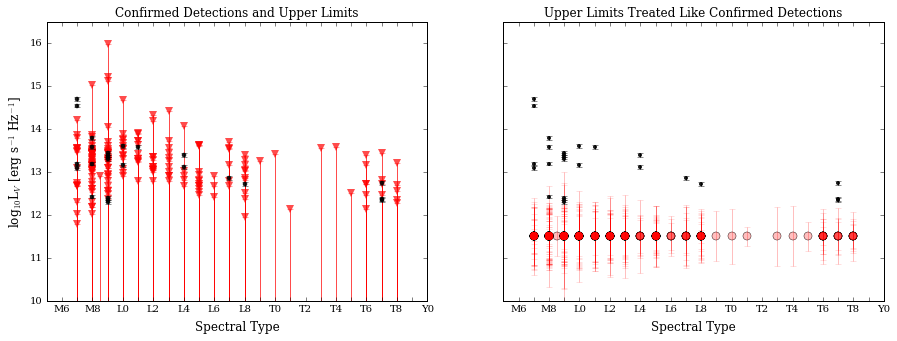

In [21]:
###===========
# This section plots the data, 1 with uplims and one with uplims-->confirmed, vs. temperature
###===========

spectype_conf = spectype[Conf_index]
spectype_ul = spectype[UL_index]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

labels = ['','M6','','M8','','L0','','L2','','L4','','L6','','L8','',
          'T0','','T2','','T4','','T6','','T8','', 'Y0']

#Upper limits not yet divided by three
ax1.set_xticks(np.arange(5,31,1))
ax1.set_xticklabels(labels)
ax1.errorbar(spectype_ul, lLVuplim, yerr=lLVuplim, uplims=np.ones(sum(UL_index), dtype=bool), ls='', c='red', markersize='8', markeredgecolor='None', alpha=0.7, fmt="v")
ax1.errorbar(spectype_conf, lLVconf, yerr=lLVconf_err, ls='', c='k', markersize='4', markeredgecolor=None, alpha=0.9, fmt="o")

ax1.set_xlim(5,30)
ax1.set_ylim(10,16.5)
ax1.set_xlabel('Spectral Type', fontsize=12, labelpad=7)
ax1.set_ylabel('log$_{10}$L$_V$ [erg s$^{-1}$ Hz$^{-1}$]', fontsize=12)
ax1.set_title('Confirmed Detections and Upper Limits')

ax2.set_xticks(np.arange(5,31,1))
ax2.set_xticklabels(labels)
ax2.errorbar(spectype_ul, lLVuplim_conf, yerr=lLVuplim_conf_err, ls='', c='None', markeredgecolor='k', markersize='8', alpha=0.9, fmt="o")
ax2.errorbar(spectype_ul, lLVuplim_conf, yerr=lLVuplim_conf_err, ls='', c='red', markeredgecolor='None', markersize='8', alpha=0.25, fmt="o")
ax2.errorbar(spectype_conf, lLVconf, yerr=lLVconf_err, ls='', c='k', markersize='4', markeredgecolor='None', alpha=0.9, fmt="o")

ax2.set_xlim(5,30)
ax2.set_xlabel('Spectral Type', fontsize=12, labelpad=7)
ax2.set_title('Upper Limits Treated Like Confirmed Detections')

In [22]:
###===========
# This section plots likelihood function for simplest model
###===========

#Likelihood function is: L=(1-P)N(y_n|mu_q, var_q) + P*N(y_n|mu_l, var_l)

P = 0.5
mu_q = 11.5
var_q = 0.3
mu_l = 13.5
var_l = 1.
yerr = lLVtotal_err
pi = math.pi

print "average_quiet is " + str(mu_q)
print "average_loud is " + str(mu_l)


P_array=[]
total_array=[]
likelihood_array=[]
dP = 0.01
for P in np.arange(0.5 * dP, 1., dP):
    yvar_q = var_q + yerr ** 2
    yvar_l = var_l + yerr ** 2
    Likelihood = (1-P)*(1/np.sqrt(2*pi*yvar_q))*(np.exp((-1/2)*((lLVtotal-mu_q)**2)/yvar_q)) \
                   + P*(1/np.sqrt(2*pi*yvar_l))*(np.exp((-1/2)*((lLVtotal-mu_l)**2)/yvar_l))
    total = np.sum(np.log10(Likelihood))
    likelihood_array.append(Likelihood)
    P_array.append(P)
    total_array.append(total)
#     print "P value is %s, Sum of ln(Likelihood) is %s" %(P, total)

print len(np.arange(0.5 * dP, 1., dP))

average_quiet is 11.5
average_loud is 13.5
100


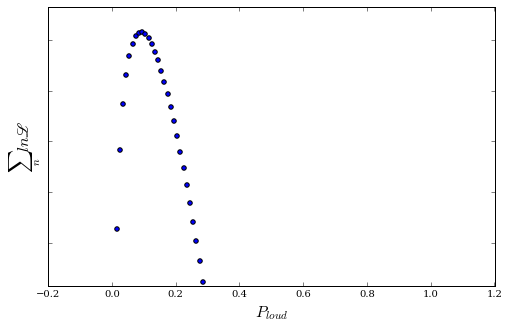

In [23]:
###===========
# This section plots the first of Hogg's graph tests
###===========

plt.figure(figsize=(8,5))
plt.scatter(P_array, total_array)
plt.xlabel("$P_{loud}$", fontsize='16')
plt.ylabel("$\sum_{n} ln\mathscr{L}$", fontsize='16')
plt.ylim(np.max(total_array)-10., np.max(total_array)+1.)
plt.tick_params(axis='y', labelleft='off')

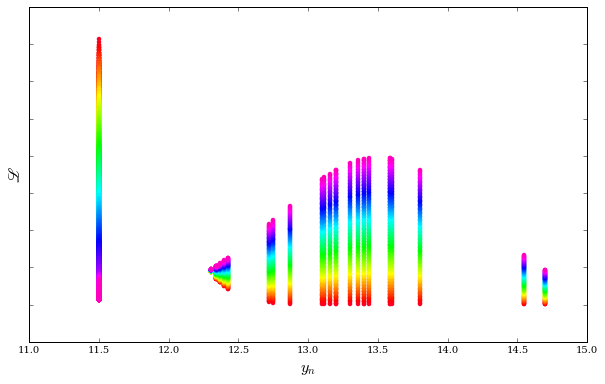

In [24]:
###===========
# This section plots the second of Hogg's graph tests for most likely P value, P=0.5
###===========

color=iter(cm.gist_rainbow(np.linspace(0,1,100)))

plt.figure(figsize=(10,6))
for i in range(0,100):
    c=next(color)
    plt.scatter(lLVtotal, likelihood_array[i], c=c, lw=0)
    plt.xlabel("$y_n$", fontsize='16')
    plt.ylabel("$\mathscr{L}$", fontsize='16')
    plt.tick_params(axis='y', labelleft='off')

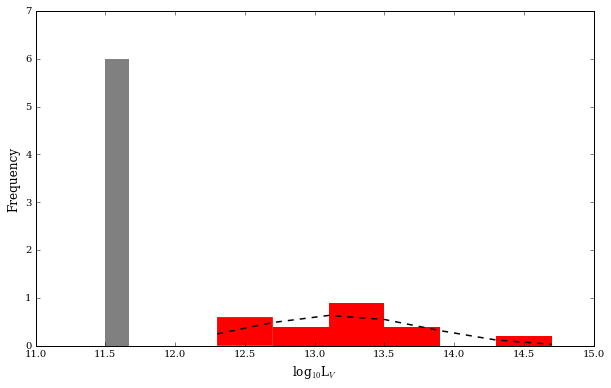

In [25]:
###===========
# This section plots histogram to compare to previous plot
###===========

plt.figure(figsize=(10,6))

(mu_l, sigma_l) = norm.fit(lLVconf) #mu is mean, sigma is width
n, bins, patches = plt.hist(lLVconf, bins=6, normed=True, facecolor='red', edgecolor='none')
y = mlab.normpdf(bins, mu_l, sigma_l)
l = plt.plot(bins, y, 'k--', linewidth=1.5)

# (mu_q, sigma_q) = norm.fit(lLVuplim_conf)
# m, bins2, patches2 = plt.hist(lLVuplim_conf, bins=6, normed=True, facecolor='grey', edgecolor='none')
plt.hist(lLVuplim_conf, bins=6, normed=True, facecolor='grey', edgecolor='none')
# z = mlab.normpdf(bins2, mu_q, sigma_q)
# l = plt.plot(bins2, z, 'k--', linewidth=1.5)

plt.xlabel("log$_{10}$L$_V$", fontsize='12')
plt.ylabel("Frequency", fontsize='12')

In [26]:
###===========
# This section defines the likelihood function, priors and probability for MCMC functionality
# We are using DFM's emcee code
###===========

import emcee

def lnlike(theta, y, yerr):
    P, mu_q, var_q, mu_l, var_l = theta
    yvar_q = var_q + yerr ** 2
    yvar_l = var_l + yerr ** 2
    Likelihood = (1-P)*(1/np.sqrt(2*pi*yvar_q))*(np.exp((-1/2)*((y-mu_q)**2)/yvar_q)) \
                   + P*(1/np.sqrt(2*pi*yvar_l))*(np.exp((-1/2)*((y-mu_l)**2)/yvar_l))
    return np.sum(np.log10(Likelihood))

def lnprior(theta):
    """
    Filled with magic numbers.
    """
    P, mu_q, var_q, mu_l, var_l = theta
    if 0 < P < 1 and 11.4 < mu_q < 11.6 and 0 < var_q < 0.3 and 12 < mu_l < 14. and 0.0001 < var_l < 4:
        return 0.0
    return -np.inf

def lnprob(theta, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr)

In [27]:
###===========
##Setting up dimensions, walkers and initialization
###===========

ndim, nwalkers = 5, 64

#initialization
theta0 = np.array([0.5, 11.5, 0.2, 13.0, 1.0])
thetas = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# if sampler in vars():
#     del sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lLVtotal, lLVtotal_err))

In [28]:
###===========
##Running the mcmc code
###===========

sampler.run_mcmc(thetas, 4096);

/Users/ellie/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


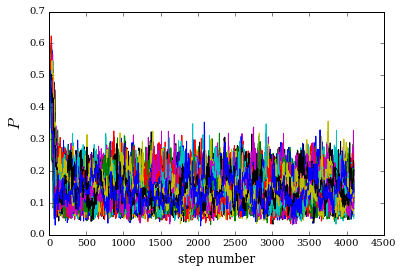

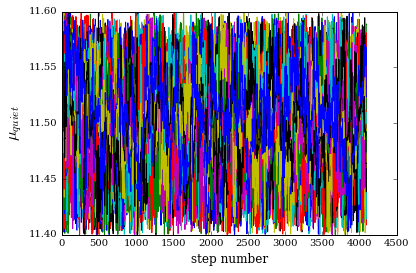

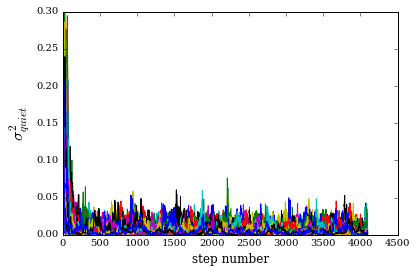

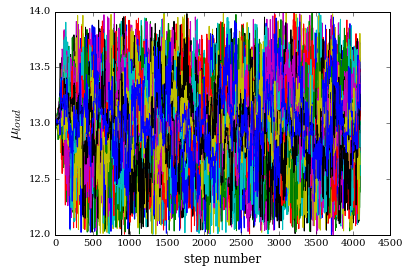

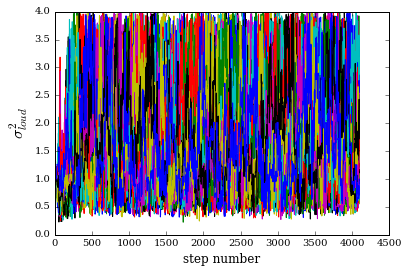

In [29]:
###===========
##This creates plots to visualize the convergence for each parameter as it's explored in the MCMC space
###===========
# this makes a pretty figure, but we could use the autocorrelation time to get quantitative about convergence.

labels = ["$P$", "$\mu_{quiet}$", "$\sigma^{2}_{quiet}$", "$\mu_{loud}$", "$\sigma^{2}_{loud}$"]
for k in range(ndim):
    plt.figure()
    for n in range(nwalkers):
        plt.plot(sampler.chain[n,:,k])
    plt.ylabel(labels[k], fontsize='16')
    plt.xlabel("step number", fontsize='12')

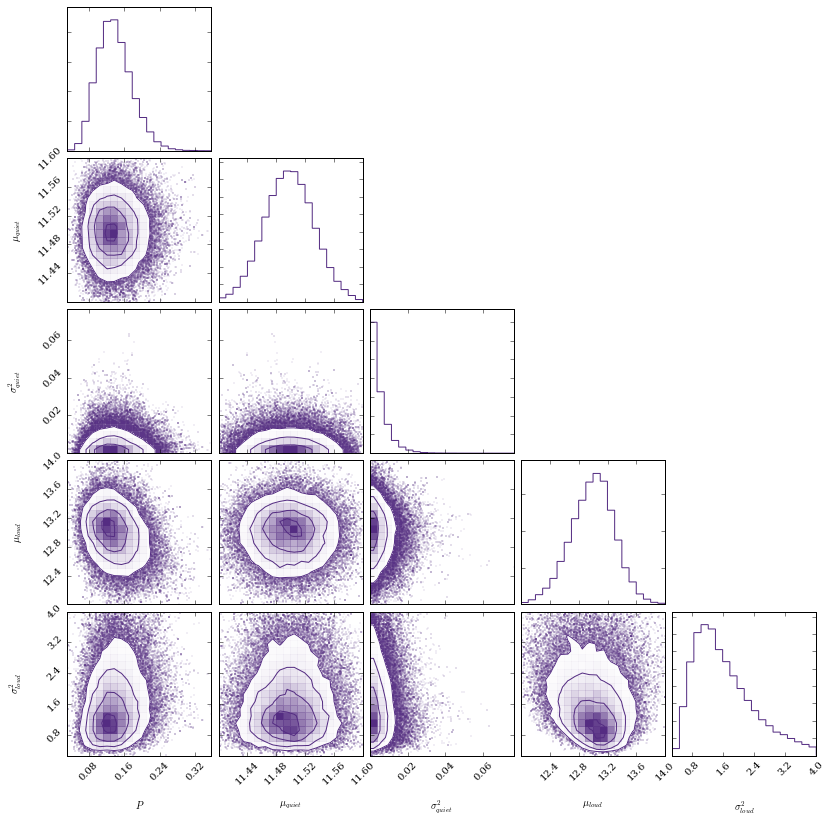

In [30]:
###===========
## This section uses DFM's triangle plot to check the validity of MCMC priors
###===========

# only show the second half of the chain
foo, nsteps, bar = sampler.chain.shape
samples = sampler.chain[:, nsteps/2:, :].reshape((-1, ndim))

import corner
fig = corner.corner(samples, labels=labels, color='#542c82')
# label_kwargs = map(fontsize,'16') change the font in rc params and see if that works
fig.savefig("triangle.png")

In [31]:
"""
What happens if we want P to vary with temperature?
Note that 3000. and 500. are magic numbers!
(If you ever get a Teff outside that range, you are in the danger zone.)

Here we add temperature into the mixture model
"""

#recreating arrays of temp and flux and index in "temperature" length
t_eff = csv[1:,13]
t_eff_err = csv[1:,14]
len_t_eff = t_eff == 0 #creating index to only get items with temp value
len_t_eff = np.logical_not(len_t_eff) #defining index properly under boolean terms

t_eff = t_eff[len_t_eff]
t_eff_err = t_eff_err[len_t_eff]

LV_T =  LV[len_t_eff]
lLV_T = lLV[len_t_eff]
lLV_err_T = lLV_err[len_t_eff]
Conf_index_T = Conf_index[len_t_eff]
UL_index_T = UL_index[len_t_eff]

lLVconf_T = lLV_T[Conf_index_T]
lLVconf_err_T = lLV_err_T[Conf_index_T]

LVuplim_T = LV_T[UL_index_T]
lLVuplim_T = np.log10(LVuplim_T)
lLVuplim_conf_T = 11.5 + np.zeros_like(LVuplim_T)
lLVuplim_conf_err_T = (lLVuplim_T - lLVuplim_conf_T) / 3.

lLVtotal_T = np.concatenate((lLVuplim_conf_T, lLVconf_T))
lLVtotal_err_T = np.concatenate((lLVuplim_conf_err_T, lLVconf_err_T))

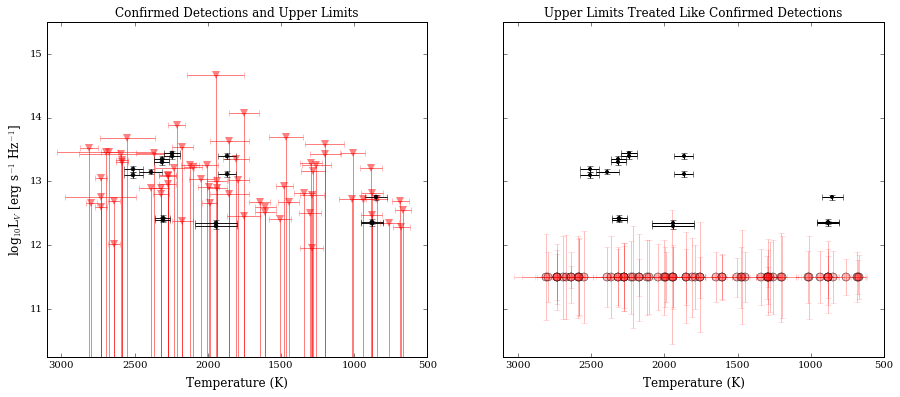

In [32]:
###===========
## This section plots according to temperature
###===========

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 6))

t_eff_ul=t_eff[UL_index_T]
t_eff_conf=t_eff[Conf_index_T]
t_eff_err_ul=t_eff_err[UL_index_T]
t_eff_err_conf=t_eff_err[Conf_index_T]

#Upper limits not yet divided by three
ax1.errorbar(t_eff_ul, lLVuplim_T, xerr=t_eff_err_ul, yerr=lLVuplim_T, uplims=np.ones(sum(UL_index_T), dtype=bool), ls='', c='red', markersize='8', markeredgecolor='None', alpha=0.5, fmt="v")
ax1.errorbar(t_eff_conf, lLVconf_T, xerr=t_eff_err_conf, yerr=lLVconf_err_T, ls='', c='k', markersize='4', markeredgecolor=None, alpha=0.9, fmt="o")

ax1.set_xlim(500, 3100)
ax1.set_ylim(10.25,15.5)
ax1.set_xlabel('Temperature (K)', fontsize=12, labelpad=7)
ax1.set_ylabel('log$_{10}$L$_V$ [erg s$^{-1}$ Hz$^{-1}$]', fontsize=12)
ax1.set_title('Confirmed Detections and Upper Limits')

ax2.errorbar(t_eff_ul, lLVuplim_conf_T, xerr=t_eff_err_ul, yerr=lLVuplim_conf_err_T, ls='', c='None', markeredgecolor='k', markersize='8', alpha=0.9, fmt="o")
ax2.errorbar(t_eff_ul, lLVuplim_conf_T, xerr=t_eff_err_ul, yerr=lLVuplim_conf_err_T, ls='', c='red', markeredgecolor='None', markersize='8', alpha=0.25, fmt="o")
ax2.errorbar(t_eff_conf, lLVconf_T, xerr=t_eff_err_conf, yerr=lLVconf_err_T, ls='', c='k', markersize='4', markeredgecolor='None', alpha=1, fmt="o")

ax2.set_xlim(500, 3100)
ax2.set_xlabel('Temperature (K)', fontsize=12, labelpad=7)
ax2.set_title('Upper Limits Treated Like Confirmed Detections')

ax1.invert_xaxis()
ax2.invert_xaxis()

In [33]:
def lnlike(theta, y, yerr, t_eff):
    P3000, P0500, mu_q, var_q, mu_l, var_l = theta
    P = P0500 + (P3000 - P0500) * (t_eff - 500.) / (3000. - 500.)
    yvar_q = var_q + yerr ** 2
    yvar_l = var_l + yerr ** 2
    Likelihood = (1-P)*(1/np.sqrt(2*pi*yvar_q))*(np.exp((-1/2)*((y-mu_q)**2)/yvar_q)) \
                   + P*(1/np.sqrt(2*pi*yvar_l))*(np.exp((-1/2)*((y-mu_l)**2)/yvar_l))
    return np.sum(np.log10(Likelihood))

def lnprior(theta):
    """
    Filled with magic numbers.
    """
    P3000, P0500, mu_q, var_q, mu_l, var_l = theta
    if 0 < P3000 < 1 and 0 < P0500 < 1 and 11.3 < mu_q < 11.7 and 0 < var_q < 0.3 and 11 < mu_l < 14. and 0.0001 < var_l < 4.5:
        return 0.0
    return -np.inf

def lnprob(theta, y, yerr, t_eff):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr, t_eff)

In [34]:
##Setting up walkers and initialization
ndim, nwalkers = 6, 64

#initialization
theta0 = np.array([0.5, 0.5, 11.5, 0.2, 13.0, 1.0])
thetas = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

if sampler in vars():
    del sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lLVtotal_T, lLVtotal_err_T, t_eff))

In [35]:
sampler.run_mcmc(thetas, 4096);

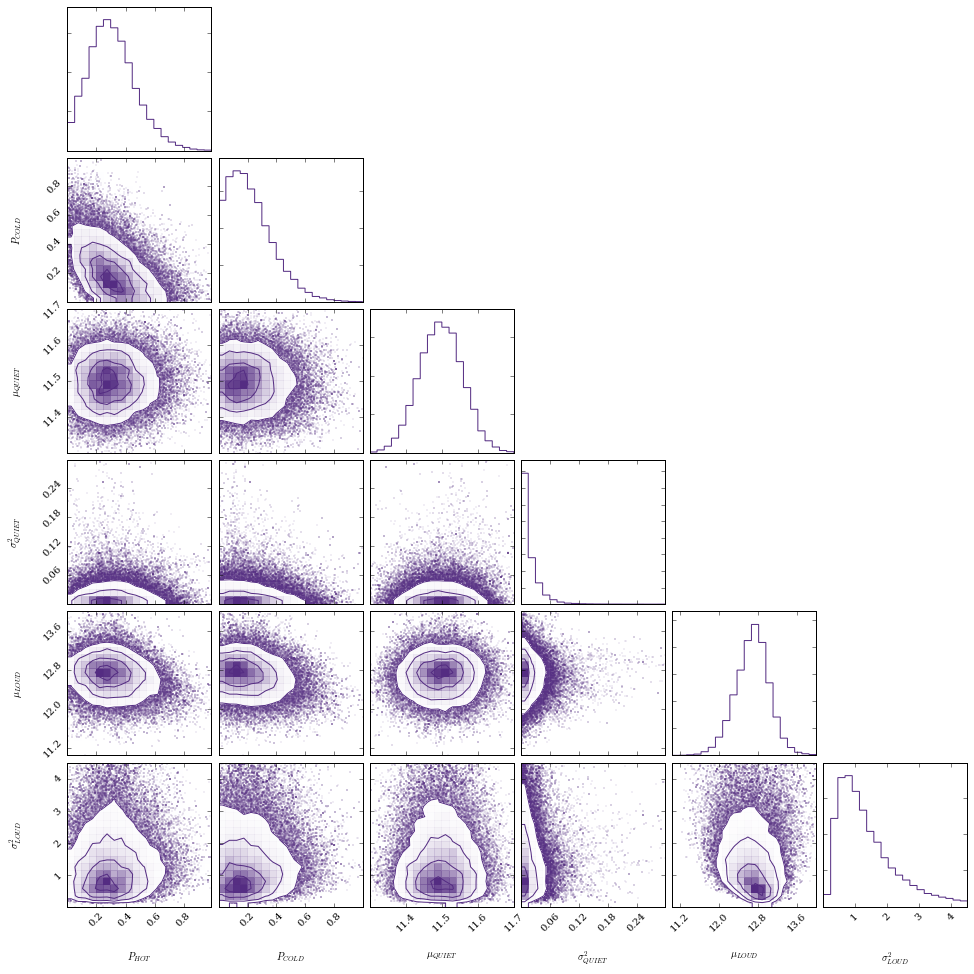

In [36]:
labels = ["$P_{HOT}$", "$P_{COLD}$", "$\mu_{QUIET}$", "$\sigma^{2}_{QUIET}$", "$\mu_{LOUD}$", "$\sigma^{2}_{LOUD}$"]

# only show the second half of the chain
foo, nsteps, bar = sampler.chain.shape
samples = sampler.chain[:, nsteps/2:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=labels, color='#542c82')
# label_kwargs = map(fontsize,'16')
fig.savefig("triangle2.png")

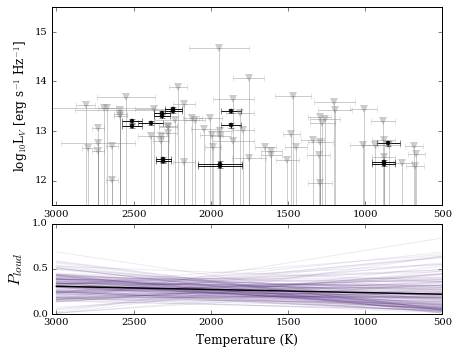

In [37]:
###===========
## This section plots the sample near the probability array
###===========

fig, ax = plt.subplots(figsize=(7, 5.5))

ax1 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3,1), (2, 0))

ax1.errorbar(t_eff_ul, lLVuplim_T, xerr=t_eff_err_ul, yerr=lLVuplim_T, uplims=np.ones(sum(UL_index_T), dtype=bool), ls='', c='grey', alpha=0.4, markersize='8', markeredgecolor='None', fmt="v")
ax1.errorbar(t_eff_conf, lLVconf_T, xerr=t_eff_err_conf, yerr=lLVconf_err_T, ls='', c='k', markersize='4', markeredgecolor=None, alpha=0.9, fmt="o")


ax1.set_xlim(500, 3030)
ax1.set_ylim(11.5,15.5)
ax1.locator_params(nbins=5, axis='y')
ax1.set_xlabel('Temperature (K)', fontsize=12, labelpad=7)
ax1.set_ylabel('log$_{10}$L$_V$ [erg s$^{-1}$ Hz$^{-1}$]', fontsize=12)
ax1.set_title('')

P3000_array=[]
P0500_array=[]
for P3000, P0500, mu_q, var_q, mu_l, var_l in samples[np.random.randint(4096, size=150)]:
    x = [500, 3000]
    y = [P0500, P3000]
    P3000_array.append(P3000)
    P0500_array.append(P0500)
    z = [mu_q, var_q, mu_l, var_l]
    ax2.plot(x, y, color="#542c82", alpha=0.1)
ax2.plot([500, 3000], [np.mean(P0500_array),np.mean(P3000_array)], color="k", linewidth=1.5)
ax2.set_xlim(500, 3030)
ax2.set_ylim(0, 1)
ax2.locator_params(nbins=4, axis='y')
ax2.set_xlabel('Temperature (K)', fontsize=12, labelpad=7)
ax2.set_ylabel('$P_{loud}$', fontsize=16, labelpad=7)

ax1.invert_xaxis()
ax2.invert_xaxis()
fig.savefig("stackedprob.png")

In [ ]:
# plt.errorbar(t_eff_ul, lLVuplim_T, xerr=t_eff_err_ul, c='red', markersize='8', markeredgecolor='None', alpha=0.5, fmt="v")
# plt.errorbar(t_eff_conf, lLVconf_T, xerr=t_eff_err_conf, yerr=lLVconf_err_T, ls='', c='k', markersize='4', markeredgecolor=None, alpha=0.9, fmt="o")

# plt.gca().invert_xaxis()
# plt.xlim(500, 3100)
# plt.ylim(10.25,15.5)
# plt.xlabel('Temperature', fontsize=12, labelpad=7)
# plt.ylabel('log$_{10}$L$_V$ [erg s$^{-1}$ Hz$^{-1}$]', fontsize=12)